In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import pickle
import torch

import warnings
warnings.filterwarnings("ignore")

# Load preprocessed data
data_preprocessed = pd.read_csv('../data/preprocessed_data/TelcoCustomerChurn_Preprocessed.csv')

# Define feature names
feature_names = data_preprocessed.columns.tolist()
feature_names.remove('Churn')
feature_names.remove('CustomerID')

# Set 'CustomerID' as the index
data_preprocessed.set_index('CustomerID', inplace=True)

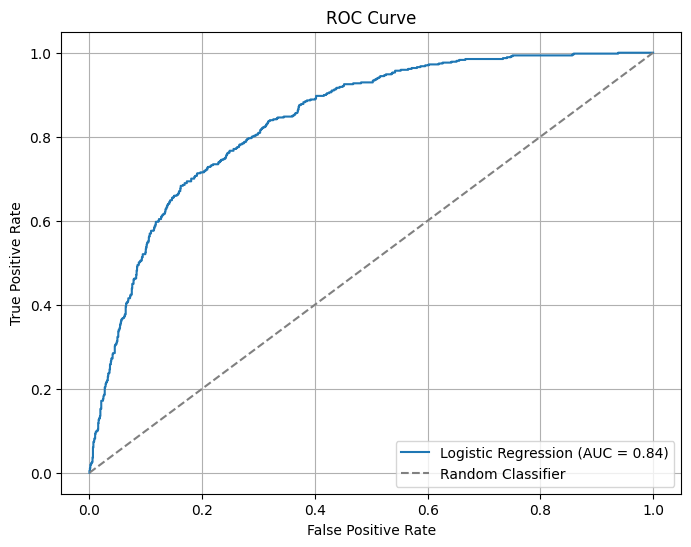

0.8401974134885393

In [2]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data_preprocessed.drop(columns=['Churn']),  # Features (excluding the target variable)
    data_preprocessed['Churn'],  # Target variable
    test_size=0.25,  # 25% of data used for testing
    random_state=42,  # Ensures reproducibility
    stratify=data_preprocessed['Churn']  # Maintains distribution of target variable
)

# Initialize and train the Logistic Regression model
logreg_model = LogisticRegression(random_state=42)
logreg_model.fit(X_train, y_train)

# Save the test data (features and target)
X_test.to_csv('../data/test_data/X_test.csv')
y_test.to_csv('../data/test_data/y_test.csv')

# Predict the probabilities on the testing set
y_test_probabilities = logreg_model.predict_proba(X_test)[:, 1]

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_test_probabilities)
fpr, tpr, _ = roc_curve(y_test, y_test_probabilities)

# Display ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

# Display ROC AUC score
roc_auc

In [ ]:
# Define hyperparameter grid
param_grid = {
    'C': np.logspace(-3, 3, 7),  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Regularization type
    'max_iter': [100, 200, 300, 400, 500],  # Max iterations for solver
    'solver': ['liblinear', 'saga']  # Solvers that can handle both L1 and L2 regularization
}

# Initialize a Logistic Regression model
logreg_model = LogisticRegression(random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    logreg_model,  # Model to be tuned
    param_grid,  # Hyperparameter options
    scoring='roc_auc',  # Evaluation metric
    cv=5,  # Cross-validation folds
    verbose=1,  # Output search results
    n_jobs=-1  # Use all available processors
)

# Perform Grid Search on the training data
grid_search.fit(X_train, y_train)
    
# Retrieve the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

In [4]:
# Refit the Logistic Regression model with the optimal hyperparameters
logreg_model_optimized = LogisticRegression(
    C=10.0, 
    max_iter=100, 
    penalty='l2', 
    solver='saga', 
    random_state=42
)
logreg_model_optimized.fit(X_train, y_train)

# Extract feature importances (coefficients) from the model
coefficients = logreg_model_optimized.coef_.flatten()

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort the features by absolute importance
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False).drop(columns='Abs_Importance')
feature_importance['Importance'] = feature_importance['Importance'].apply(lambda x: abs(x))

# Display top 10 features
feature_importance.to_csv('../data/preprocessed_data/feature_importance.csv', index = False)

In [5]:
model_filename = '../models/mlModel.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(logreg_model_optimized, file)